In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from skimage import data
%matplotlib inline

In [2]:
def window_sum_2d(image, window_shape):
    window_sum = np.cumsum(image, axis=0)
    window_sum = (window_sum[window_shape[0]:-1] - window_sum[:-window_shape[0] - 1])
    window_sum = np.cumsum(window_sum, axis=1)
    window_sum = (window_sum[:, window_shape[1]:-1] - window_sum[:, :-window_shape[1] - 1])
    return window_sum

In [3]:
def match_template(image, template):
    image = np.pad(np.array(image), pad_width=tuple((width, width) for width in template.shape))

    image_window_sum = window_sum_2d(image, template.shape)
    image_window_sum_squared = window_sum_2d(image ** 2, template.shape)

    template_mean = template.mean()
    template_volume = np.prod(template.shape)
    template_ssd = np.sum((template - template_mean) ** 2)

    xcorr = fftconvolve(image, template[::-1, ::-1], mode="valid")[1:-1, 1:-1]

    numerator = xcorr - image_window_sum * template_mean

    denominator = np.sqrt(np.maximum((
        image_window_sum_squared - image_window_sum_squared / template_volume) * template_ssd, 0
    ))

    response = np.zeros(xcorr.shape)
    mask = denominator > 1e-7
    response[mask] = numerator[mask] / denominator[mask]

    slices = []
    for i in range(2):
        d0 = template.shape[i] - 1
        d1 = d0 + image.shape[i] - template.shape[i] + 1
        slices.append(slice(d0, d1))

    return response[slices]

In [4]:
image = data.coins()
coin = image[170:220, 75:130]

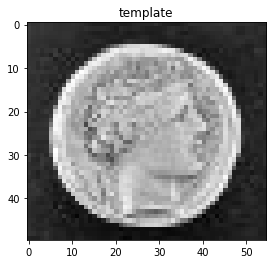

In [5]:
plt.figure(figsize=(5, 4))
plt.title('template')
plt.imshow(coin, cmap=plt.cm.gray);

In [6]:
result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

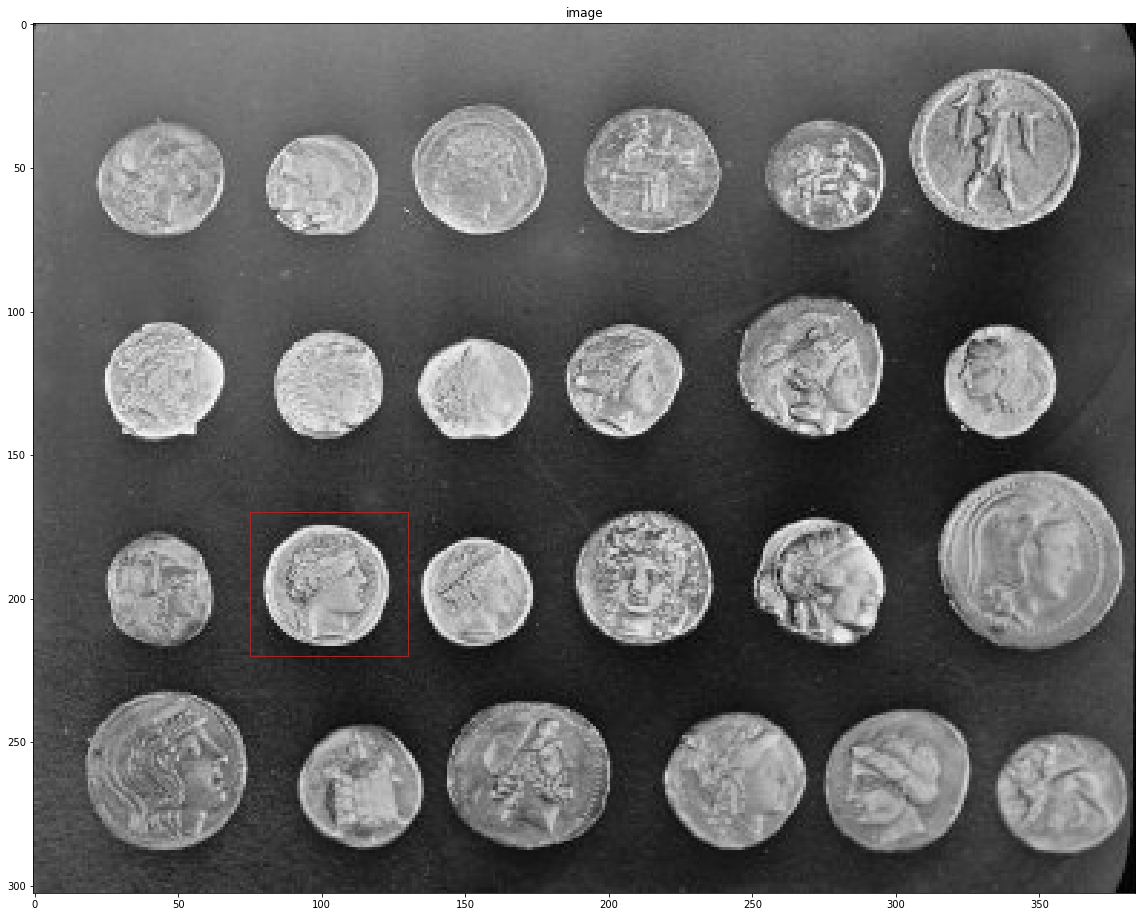

In [7]:
fig, ax = plt.subplots(1, figsize=(20, 16))
ax.set_title('image')
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.imshow(image, cmap=plt.cm.gray);

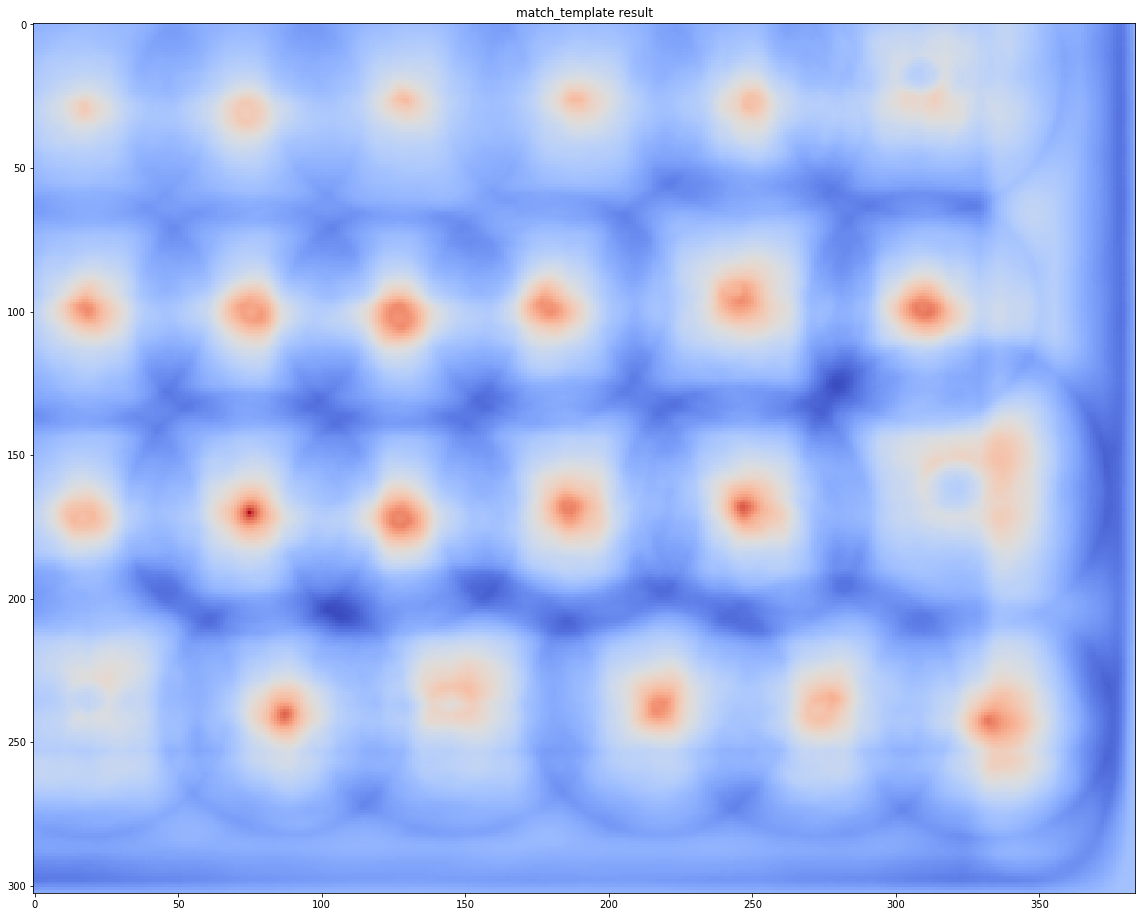

In [8]:
plt.figure(figsize=(20, 16))
plt.title('match_template result')
plt.imshow(result, cmap='coolwarm');